## Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit, Parameter, Parameters, Covariance


import warnings
import sys
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
warnings.filterwarnings('ignore')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_standard = 'green'
color_nui = 'red'

## Definitions 

In [2]:
def plot_residual_comparison(dataset1, dataset2, elist, radius = 1.0*u.deg, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(len(elist)*1,3 ,figsize =(15,len(elist)*5))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        
        estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=dataset1.counts.geom.axes['energy'].edges) 
        result1 = estimator.run(dataset1) 
        result2 = estimator.run(dataset2) 
        residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.data))
        print("vmax_:", vmax_)   
        residual2.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][1],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][0],
                                                        vmax = vmax_, vmin = -vmax_)
                
        n, bins, patches = axs[i][2].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = color_standard, alpha = 0.5)
        axs[i][2].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = color_nui, alpha = 0.5)



        axs[i][2].legend(fontsize = 14)
        axs[i][2].set_xlabel('Significance'); axs[i][2].set_yscale('log')
        axs[i][1].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[i][0].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig

def plot_residual_comparison_vertical(dataset1, dataset2, elist, radius = 1.0*u.deg, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(3, len(elist)*1 ,figsize =(len(elist)*5, 15))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        
        estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=dataset1.counts.geom.axes['energy'].edges) 
        result1 = estimator.run(dataset1) 
        result2 = estimator.run(dataset2) 
        residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[1][i],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[0][i],
                                                        vmax = vmax_, vmin = -vmax_)
        cbar = axs[0][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        cbar = axs[1][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        
        
        n, bins, patches = axs[2][i].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = color_standard, alpha = 0.5)
        axs[2][i].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = color_nui, alpha = 0.5)



        axs[2][i].legend(fontsize = 14)
        axs[2][i].set_xlabel('Significance'); axs[2][i].set_yscale('log')
        axs[1][i].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[0][i].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig


def plot_residual_comparison_vertical_nohisto(dataset1, dataset2, elist, radius = 1.0*u.deg, ):
    print("Radius:", radius)
    vmax_= 4
    fig, axs = plt.subplots(2, len(elist)*1 ,figsize =(len(elist)*5, 10))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        
        estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=dataset1.counts.geom.axes['energy'].edges) 
        result1 = estimator.run(dataset1) 
        result2 = estimator.run(dataset2) 
        residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        
        
        print("residual1.data:", np.nanmax(residual1.data))
        #vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[1][i],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[0][i],
                                                        vmax = vmax_, vmin = -vmax_)
        cbar = axs[0][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        cbar = axs[1][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        
        mu = np.nanmean(residual1.data)
        sigma = np.nanstd(residual1.data)
        axs[0][i].text(105,120, f"$\\mu$ = {mu:.2} \n$\sigma$ = {sigma:.2}", fontsize = 14)
        sigma = np.nanmean(residual2.data)
        mu = np.nanstd(residual2.data)
        axs[1][i].text(105,120, f"$\\mu$ = {mu:.2} \n$\sigma$ =  {sigma:.2}", fontsize = 14)

        axs[1][i].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"Energy: [{ee_start.value:.2} : {ee_end.value:.2}] TeV"
        axs[0][i].set_title(ee + '\n Standard Analysis' ,fontsize = 14)
        axs[1][i].set_title(ee + '\n With Nuisance Parameters' ,fontsize = 14)
        

        plt.tight_layout()
    return fig



## Import of Datasets

In [3]:
source = "Crab"

In [4]:
path = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'



#dataset_standard = MapDataset.read(f'{path}/{source}/Crab_fullsys.fits')
# here the dataset with the fine binning is saved
dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)

models = Models.read(f'standard_model.yml')
models.parameters['lon_0'].frozen = True
models.parameters['lat_0'].frozen = True

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models
dataset_standard.geoms['geom']


fit_standarad = Fit(store_trace=False)
result_standarad = fit_standarad.run([dataset_standard])


In [5]:
added = '_008_69'
ebins = range(6,24)
print(ebins)
path = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset'

pathsource = f"{source}/"
dataset_N_10 = MapDatasetNuisance.read(f"{path}/{pathsource}nui_dataset{added}.fits")
print(f'opening ... {path}/{pathsource}')
with open(f'{path}/{pathsource}nui_par{added}.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
with open(f'{path}/{pathsource}nui_model{added}.yml', "r") as ymlfile:
    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(f'{path}/{pathsource}nui_bgmodel{added}.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N_10.models =models
dataset_N_10.geoms['geom']

dataset_standard.mask_safe = dataset_N_10.mask

print(dataset_N_10)

range(6, 24)
opening ... /home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/Crab/
MapDatasetNuisance
------------------

  Name                            : udHW_qVs 

  Total counts                    : 545294 
  Total background counts         : 509599.28
  Total excess counts             : 35694.72

  Predicted counts                : 545295.46
  Predicted background counts     : 507962.32
  Predicted excess counts         : 37333.14

  Exposure min                    : 2.08e-01 m2 s
  Exposure max                    : 2.25e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 191616 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1941171.35

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : main source
    Datasets names            : None
    Spectral

In [29]:
## try to read pseudo dataset:

dataset_pseudo = dataset_standard.copy()
dataset_pseudo.background = dataset_N_10.npred_background()
with open(f'{path}/{pathsource}pseudo_model{added}.yml', "r") as ymlfile:
    best_fit_model_pseudo = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(f'{path}/{pathsource}pseudo_bgmodel{added}.yml', "r") as ymlfile:
    best_fit_bgmodel_pseudo = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model_pseudo = FoVBackgroundModel(dataset_name=dataset_pseudo.name)
bkg_model_pseudo.parameters['norm'].value = best_fit_bgmodel_pseudo['spectral']['parameters'][0]['value']
bkg_model_pseudo.parameters['tilt'].value = best_fit_bgmodel_pseudo['spectral']['parameters'][1]['value']
bkg_model_pseudo.parameters['norm'].error = best_fit_bgmodel_pseudo['spectral']['parameters'][0]['error']
bkg_model_pseudo.parameters['tilt'].error = best_fit_bgmodel_pseudo['spectral']['parameters'][1]['error']
models_pseudo = Models.from_dict(best_fit_model_pseudo )
models_pseudo.append(bkg_model_pseudo)
dataset_pseudo.models =models_pseudo

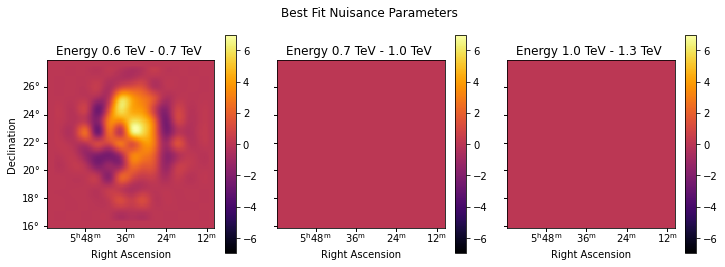

In [7]:
N_map = dataset_N_10.N_map().slice_by_idx(dict(energy=slice(ebins[0],ebins[3])))
N_map.data *=100
vmax = np.nanmax(np.abs(N_map.data))
N_map.plot_grid(
    add_cbar = True, vmax =vmax, vmin = -vmax, cmap = 'inferno');
ax = plt.gca()
fig= plt.gcf()
#cbar = plt.gca().images[-1].colorbar
#cbar.set_label('% of BG', rotation=90)
plt.suptitle(f'Best Fit Nuisance Parameters ')
name = f'plots/2_N_parameters.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')
name = f'plots/2_N_parameters.pdf'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

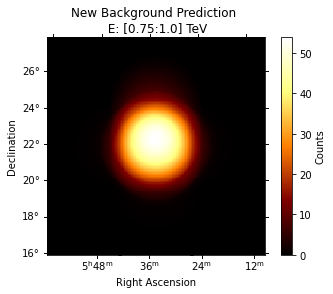

In [8]:
bg = dataset_N_10.npred_background().slice_by_idx(dict(energy=slice(7,8)))
vmax = np.nanmax(np.abs(bg.data))
bg.plot(
    add_cbar = True, );
ax = plt.gca()
fig= plt.gcf()
cbar = plt.gca().images[-1].colorbar
cbar.set_label('Counts', rotation=90)
ax.set_title(f'New Background Prediction \n E: [{0.75}:{1.0}] TeV', )
name = f'plots/2_BG_prediction.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

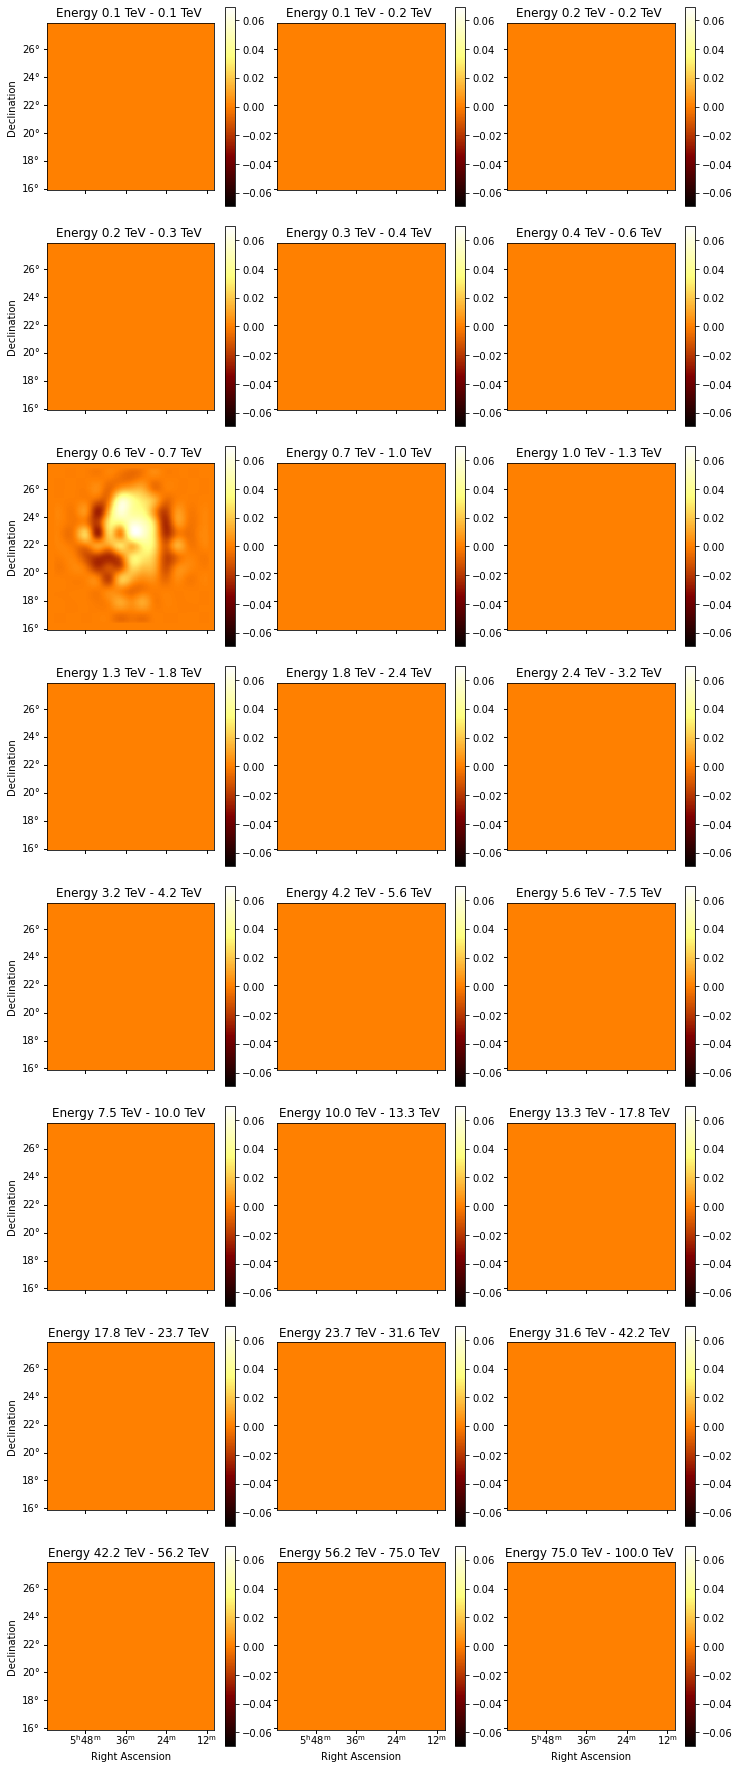

In [9]:
vmax = np.nanmax(np.abs(dataset_N_10.N_map().data))
dataset_N_10.N_map().plot_grid(add_cbar = True, vmax =vmax, vmin = -vmax);

1.3234007211012218


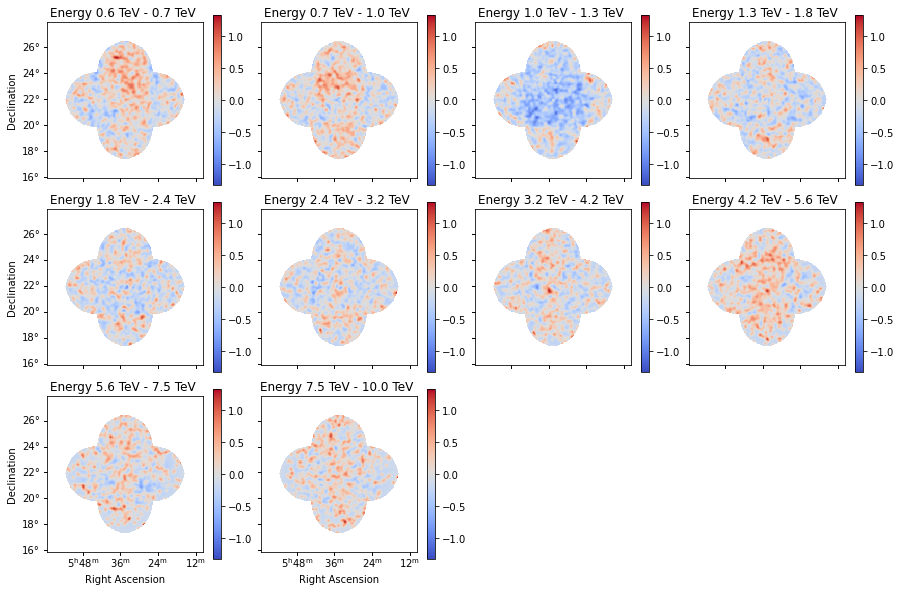

In [10]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(np.nan_to_num(res_standard.data)))
print(vmax)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

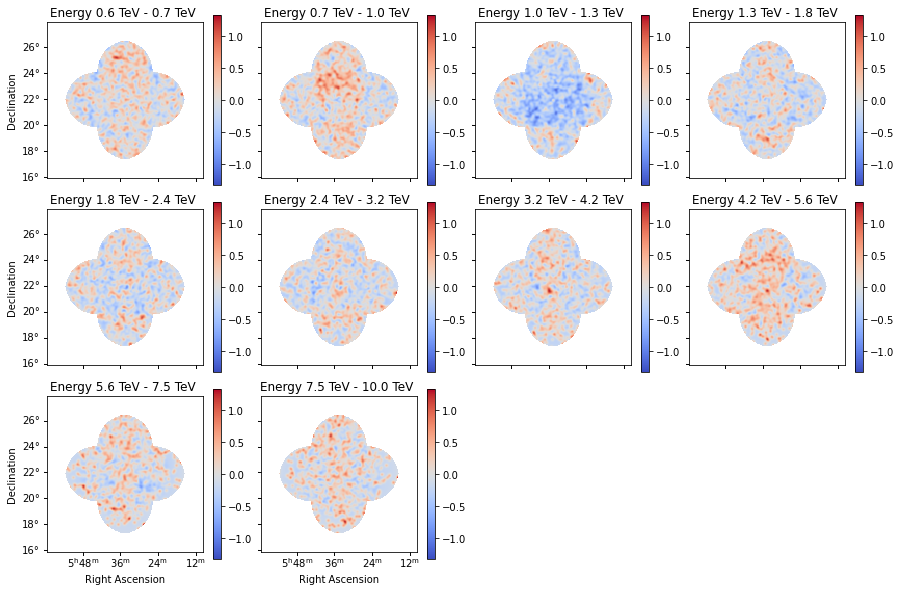

In [11]:
res_nui = (
    dataset_N_10.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
res_nui.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

## Comparison of the Spatial Resiudal Maps

In [12]:
#(dataset_N_10.background - dataset_N_10.npred_background()).plot_grid(add_cbar = 1);

In [13]:
def create_MapDataset(dataset_N):
    mapdatset = MapDataset(models=None, 
                          counts=dataset_N.counts,
                          exposure=dataset_N.exposure,
                          background=None,
                          psf=dataset_N.psf,
                          edisp=dataset_N.edisp,
                          mask_safe=dataset_N.mask_safe,
                          mask_fit=dataset_N.mask_fit,
                          gti=dataset_N.gti,
                          meta_table=dataset_N.meta_table, 
                          name=dataset_N.name)
    
    bkg_model = FoVBackgroundModel(dataset_name=mapdatset.name) 
    models = Models([dataset_N.models[0].copy()])
    print(models)
    mapdatset.models = models
    mapdatset.background = dataset_N.npred_background()
    return mapdatset




dataset_N_10_pseudo = create_MapDataset(dataset_N_10)

Models

Component 0: SkyModel

  Name                      : 1b06yMQK
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.73e-11   +/- 2.5e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.555   +/-    0.01             
    beta                    :      0.085   +/-    0.01             
    lon_0        (frozen)   :     83.631       deg         
    lat_0        (frozen)   :     22.018       deg         
    sigma                   :      0.019   +/-    0.00 deg         
    e            (frozen)   :      0.000                   
    phi          (frozen)   :      0.000       deg         




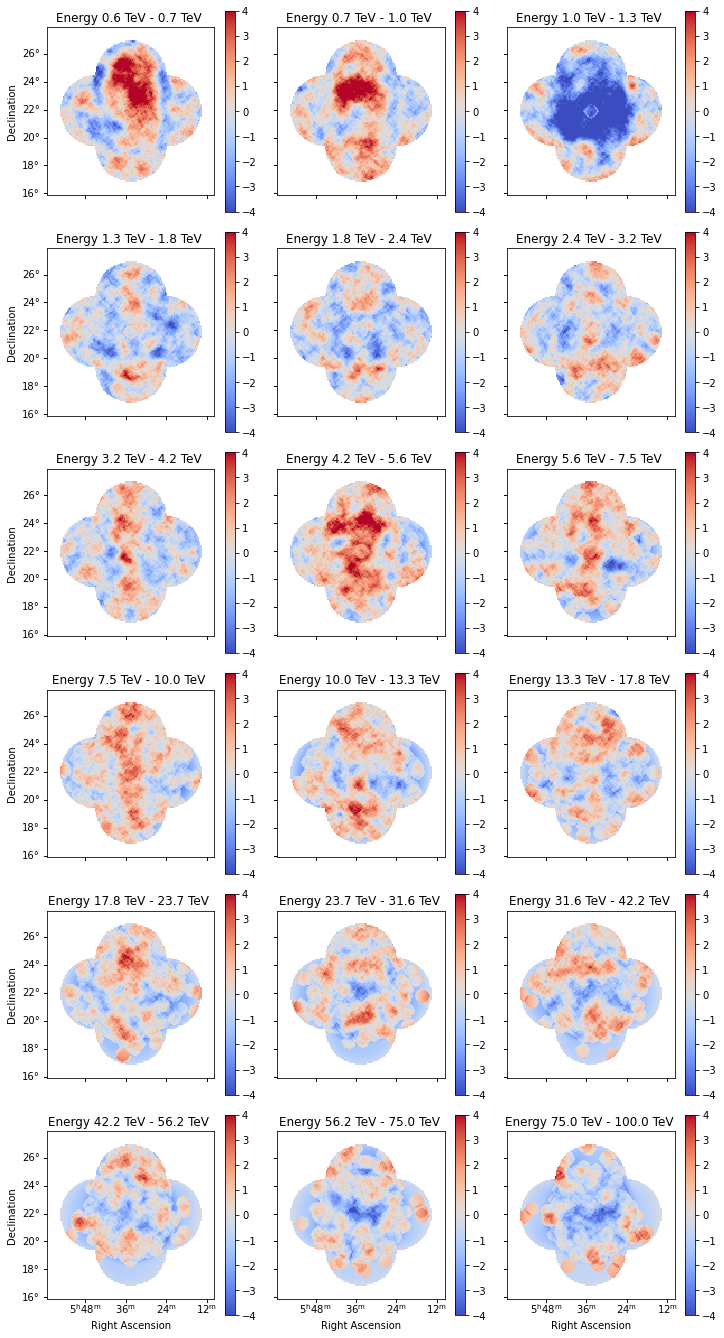

In [14]:
estimator = ExcessMapEstimator( correlation_radius=0.5 *u.deg , 
                                       energy_edges=dataset_standard.counts.geom.axes['energy'].edges[ebins[0]:]) 
result1 = estimator.run(dataset_standard)
vmax = 4
result1["sqrt_ts"].plot_grid(cmap = 'coolwarm', add_cbar =1, vmax =vmax, vmin = -vmax);
#result2 = estimator.run(dataset2) 

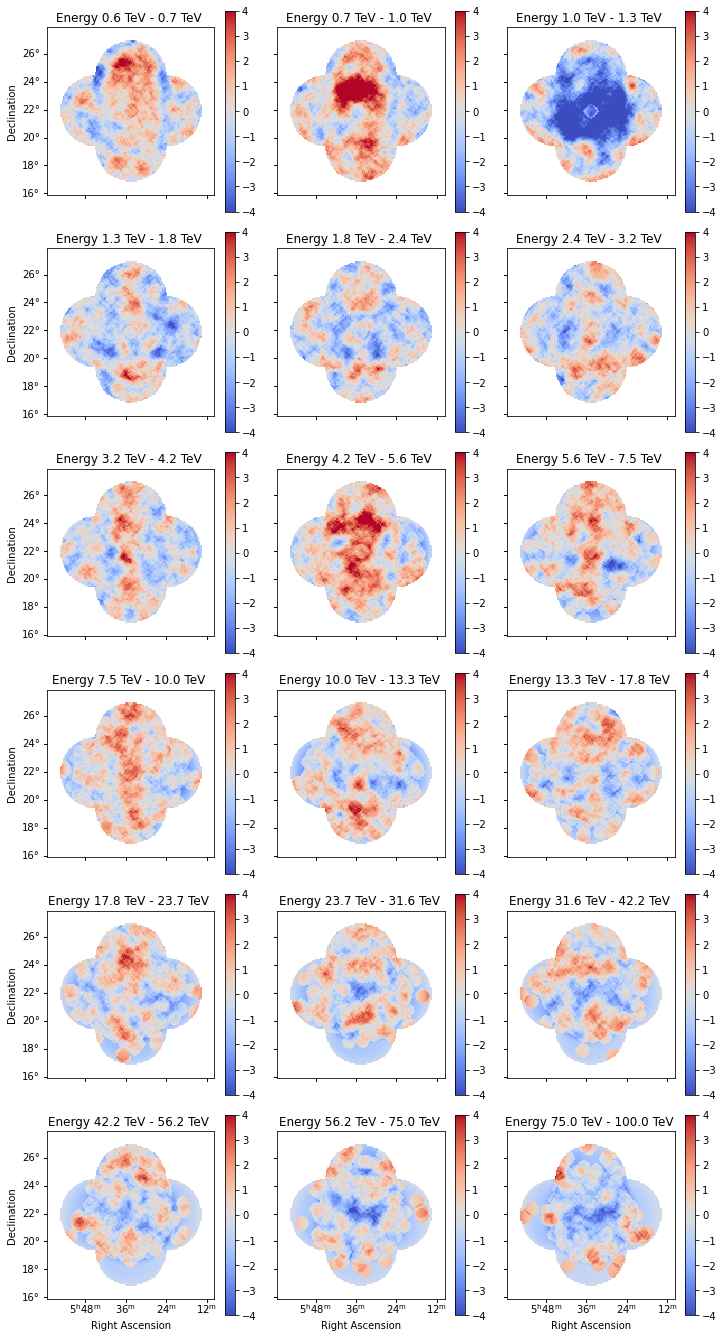

In [15]:
estimator = ExcessMapEstimator( correlation_radius=0.5 *u.deg , 
                                       energy_edges=dataset_N_10_pseudo.counts.geom.axes['energy'].edges[ebins[0]:]) 
result1 = estimator.run(dataset_N_10_pseudo)
vmax = 4
result1["sqrt_ts"].plot_grid(cmap = 'coolwarm', add_cbar =1, vmax =vmax, vmin = -vmax);
#result2 = estimator.run(dataset2) 

Radius: 0.1 deg
8
residual1.data: 4.283466
vmax_: 4.376979


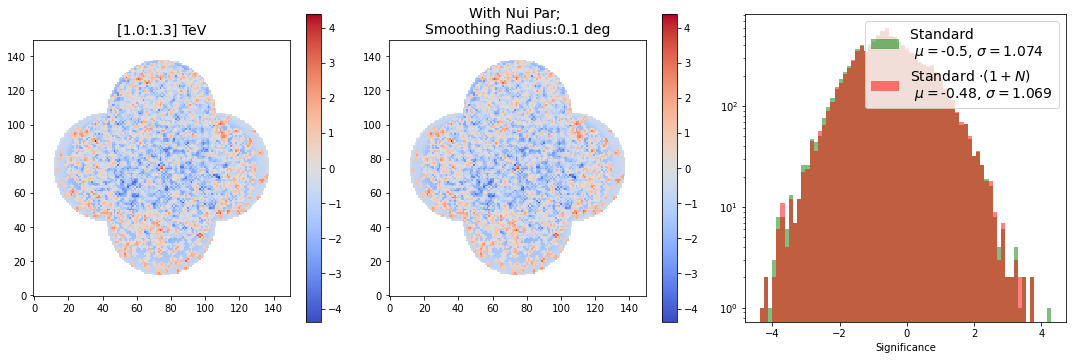

In [16]:
fig = plot_residual_comparison(dataset_standard, dataset_N_10_pseudo,[8] , radius = 0.1*u.deg )

Radius: 0.07 deg
6
residual1.data: 3.6319513
vmax_: 1.4365445217363986
7
residual1.data: 3.7914498
vmax_: 1.398247742840645
8
residual1.data: 3.9972124
vmax_: 1.646735019042418
9
residual1.data: 3.6394513
vmax_: 1.292077149210465


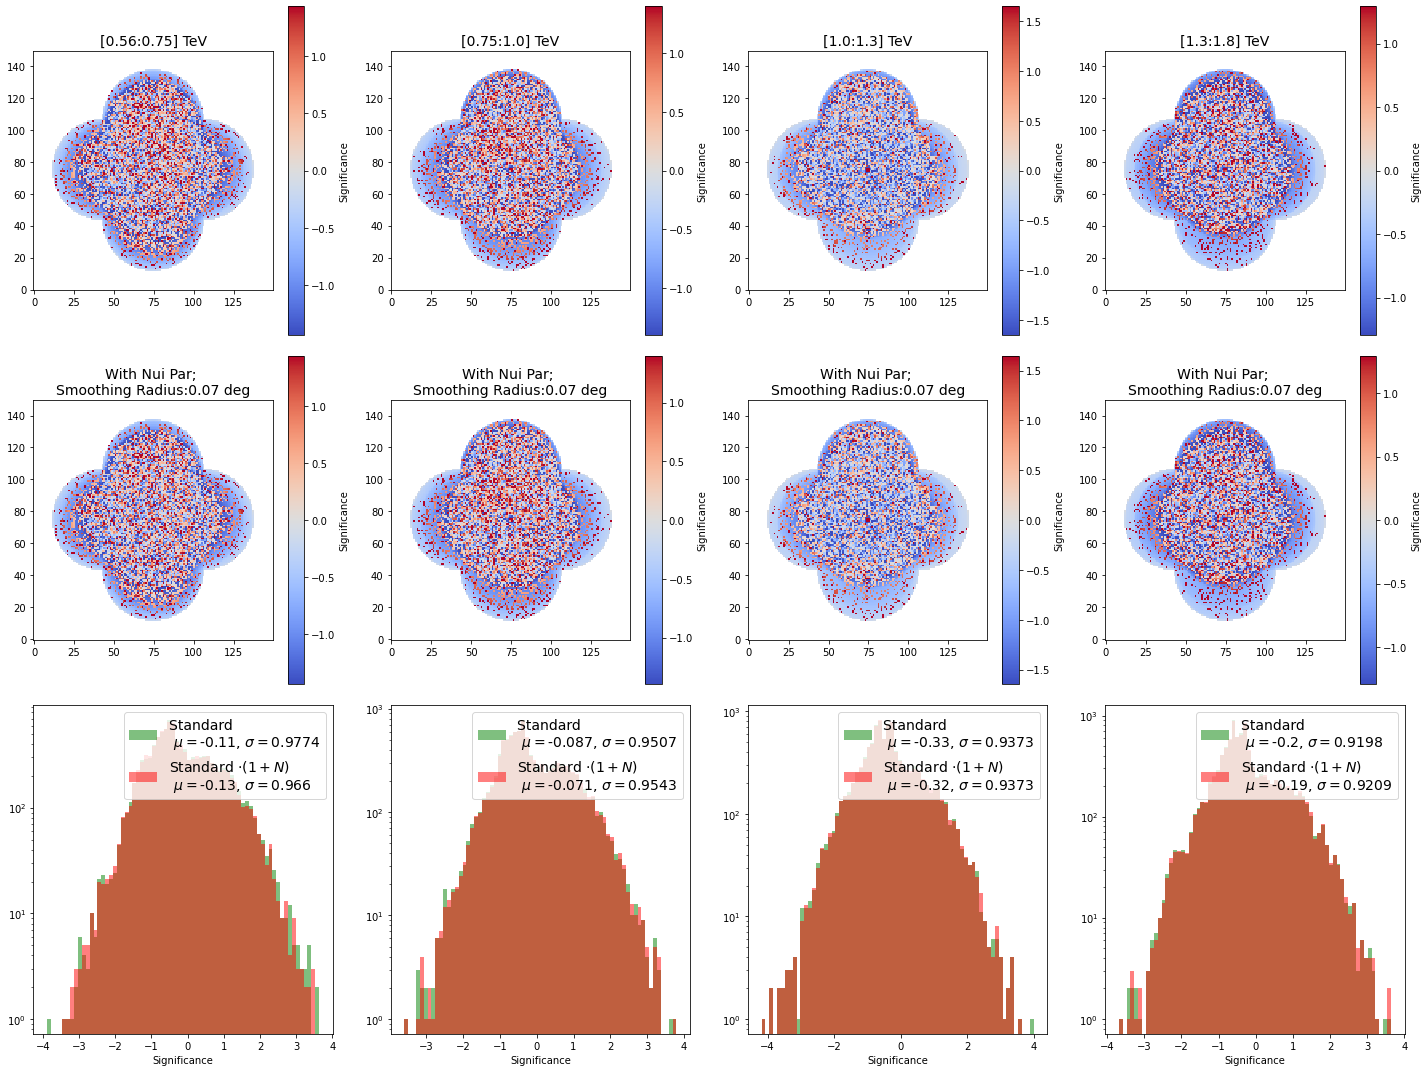

In [17]:

fig = plot_residual_comparison_vertical(dataset_standard, dataset_N_10_pseudo,[6,7,8,9] , radius = 0.07*u.deg)
#name = f'{source}/plots/Sigmaps.png'
#fig.savefig(name, dpi=300, bbox_inches = 'tight')

Radius: 0.3 deg
6
residual1.data: 5.5320444
vmax_: 4
7
residual1.data: 4.558967
vmax_: 4
8
residual1.data: 3.2919145
vmax_: 4


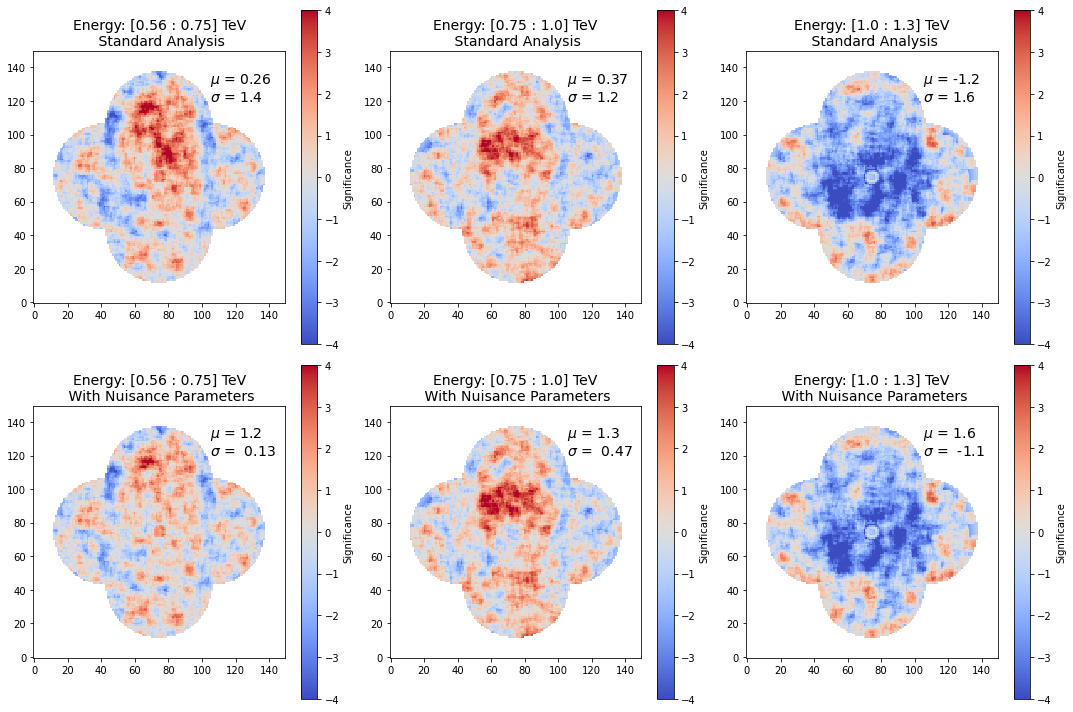

In [18]:

fig = plot_residual_comparison_vertical_nohisto(dataset_standard, dataset_N_10_pseudo,[6,7,8] , 
                                                radius = 0.3*u.deg)
ax = plt.gca()

name = f'plots/2_Sigmaps.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

In [19]:
def plot_residual_histo(dataset1, dataset2, 
                                                radius = 0.3*u.deg, i_start= 6 , i_end = 9):
    
    print("Radius:", radius)
    fig, axs = plt.subplots(1, 1 ,figsize =(5,5))
        
    estimator = ExcessMapEstimator( correlation_radius=radius , 
                                   energy_edges=dataset1.counts.geom.axes['energy'].edges) 
    result1 = estimator.run(dataset1) 
    result2 = estimator.run(dataset2) 
    residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(i_start,i_end)))
    residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(i_start,i_end)))

    print("residual1.data:", np.nanmax(residual1.data))
    vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
    print("vmax_:", vmax_)   

    n, bins, patches = axs.hist(residual1.data.flatten(),bins = 70,
                       label = 'Standard Analysis\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                       np.nanmean(residual1.data.flatten()),
                       np.nanstd(residual1.data.flatten())),
                              color = color_standard, alpha = 0.99)
    axs.hist(residual2.data.flatten(),bins = bins,
                             label = 'With Nuisance Par.\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual2.data.flatten()),
                           np.nanstd(residual2.data.flatten())),
                       color =color_nui, alpha = 0.9)



    axs.legend(fontsize = 14)
    axs.set_xlabel('Significance'); axs.set_yscale('log')
    ee = dataset1.geoms['geom'].axes[0]
    ee_start = ee.edges[i_start]
    ee_end = ee.edges[i_end]
    ee = f"[{ee_start.value:.2} : {ee_end.value:.2}] TeV"
    axs.set_title(ee ,fontsize = 14)

    plt.tight_layout()
    return fig




Radius: 0.3 deg
residual1.data: 5.5320444
vmax_: 4.440805245860681


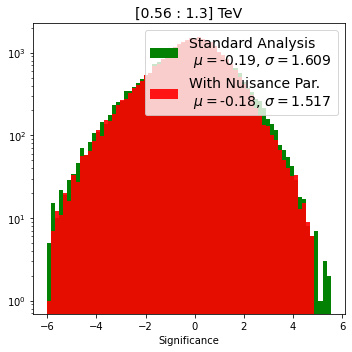

In [20]:

fig = plot_residual_histo(dataset_standard, dataset_N_10_pseudo, 
                                                radius = 0.3*u.deg, i_start= 6 , i_end = 9)
name = f'plots/2_SigmaHisto.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')
name = f'plots/2_SigmaHisto.pdf'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

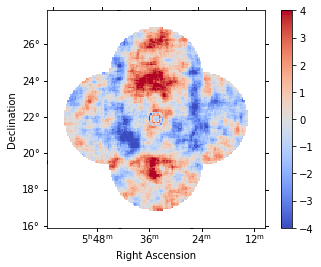

In [21]:
eedges = dataset_N_10_pseudo.counts.geom.axes['energy'].edges[0], dataset_N_10_pseudo.counts.geom.axes['energy'].edges[-1]
estimator = ExcessMapEstimator( correlation_radius=0.3 *u.deg , 
                                       energy_edges=eedges
                              ) 
result1 = estimator.run(dataset_N_10_pseudo)
vmax = 4
result1["sqrt_ts"].plot(cmap = 'coolwarm', add_cbar =1, vmax =vmax, vmin = -vmax);
#result2 = estimator.run(dataset2) 

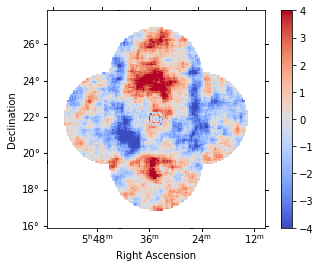

In [22]:
result1 = estimator.run(dataset_standard)
vmax = 4
result1["sqrt_ts"].plot(cmap = 'coolwarm', add_cbar =1, vmax =vmax, vmin = -vmax);
#result2 = estimator.run(dataset2) 

Radius: 0.001 deg
residual1.data: 3.9972255
vmax_: 4.185211181640625
Radius: 0.001 deg
residual1.data: 4.0961795
vmax_: 4.096179485321045
Radius: 0.001 deg
residual1.data: 4.238127
vmax_: 4.2381272315979
Radius: 0.001 deg
residual1.data: 4.1766186
vmax_: 4.176618576049805


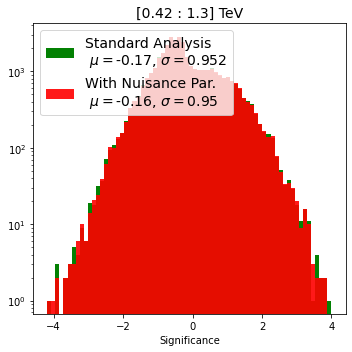

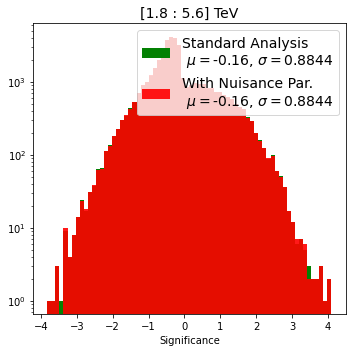

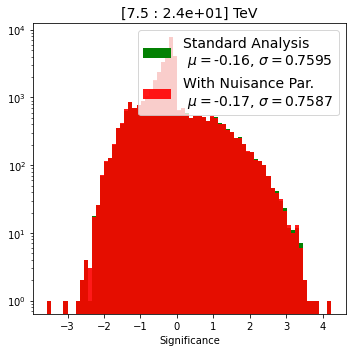

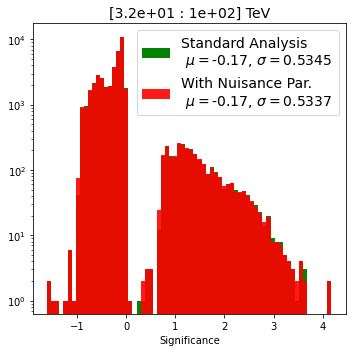

In [23]:
for i in [5,10,15,20]:
    fig = plot_residual_histo(dataset_standard, dataset_N_10_pseudo, 
                                                radius = 0.001*u.deg, i_start= i , i_end = i+4)

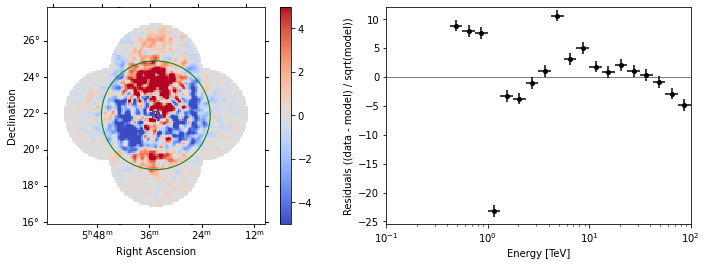

In [24]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

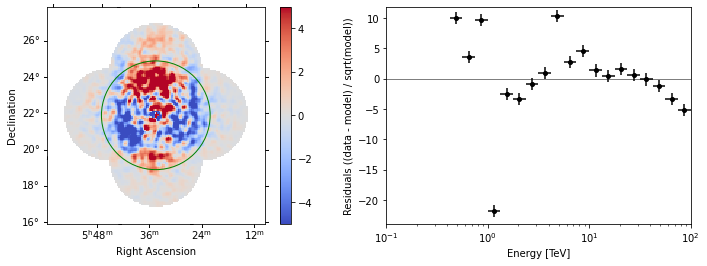

In [25]:
dataset_N_10.plot_residuals(kwargs_spectral=kwargs_spectral);

[1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.00000000e+01 1.33352143e+01 1.77827941e+01 2.37137371e+01
 3.16227766e+01 4.21696503e+01 5.62341325e+01 7.49894209e+01
 1.00000000e+02]


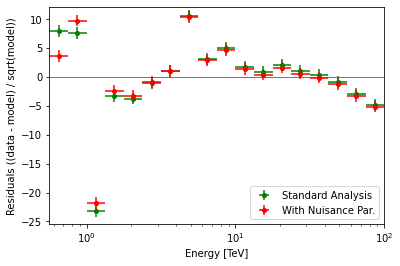

In [26]:
ax = dataset_standard.plot_residuals_spectral(method = kwargs_spectral["method"],
                                    region = kwargs_spectral["region"],
                                        color = color_standard,
                                        label = "Standard Analysis")
ylim = ax.get_ylim()
dataset_N_10.plot_residuals_spectral(ax = ax ,method = kwargs_spectral["method"],
                                    region = kwargs_spectral["region"],
                                         color = color_nui,
                                         label = "With Nuisance Par.")
ax.set_ylim(ylim[0], ylim[1])
eax = dataset_standard.geoms['geom'].axes[0].edges.value
print(eax)
ax.set_xlim(eax[6], eax[-1])
ax.legend(loc = 'lower right')
fig = plt.gcf()
name = f'plots/2_Spectral_Residuals.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')
name = f'plots/2_Spectral_Residuals.pdf'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

## Comparison of the Best Fit Model Parameters

In [30]:
print(" with nuisance")
print("(without nuisance)")

for p_N, p_stand , p_pseudo in zip(dataset_N_10.models.parameters,
                                   dataset_standard.models.parameters,
                                  dataset_pseudo.models.parameters):
    print()
    print('='*50)
    print(p_N.name )
    print('-'*50)
    print(" {:.4} +- {:.3} +- {:.3}".format(p_N.value, float(p_pseudo.error) ,
                                            float(p_N.error)- float(p_pseudo.error)  )   ) 
    print('({:.4} +- {:.3})'.format(p_stand.value, float(p_stand.error) ))




 with nuisance
(without nuisance)

amplitude
--------------------------------------------------
 3.731e-11 +- 2.51e-13 +- 2.08e-15
(3.729e-11 +- 2.51e-13)

reference
--------------------------------------------------
 1.0 +- 0.0 +- 0.0
(1.0 +- 0.0)

alpha
--------------------------------------------------
 2.555 +- 0.0143 +- 0.000276
(2.557 +- 0.0143)

beta
--------------------------------------------------
 0.08547 +- 0.00778 +- 7.07e-05
(0.08412 +- 0.00776)

lon_0
--------------------------------------------------
 83.63 +- 0.0 +- 0.0
(83.63 +- 0.0)

lat_0
--------------------------------------------------
 22.02 +- 0.0 +- 0.0
(22.02 +- 0.0)

sigma
--------------------------------------------------
 0.01859 +- 0.00123 +- 9.28e-07
(0.01856 +- 0.00123)

e
--------------------------------------------------
 0.0 +- 0.0 +- 0.0
(0.0 +- 0.0)

phi
--------------------------------------------------
 0.0 +- 0.0 +- 0.0
(0.0 +- 0.0)

norm
--------------------------------------------------
 0.990

In [31]:
sysamplitude_percentage = np.loadtxt((f'sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100
print(sysamplitude_percentage)

[ 0.          0.          0.          0.          0.          0.05364812
  0.02510288  0.0238672  -0.09008346 -0.0232704  -0.00747471  0.00899063
  0.01297704  0.08916167  0.02988208  0.03211004  0.03141786  0.0353519
  0.04056004  0.04720887  0.          0.          0.          0.        ]


In [32]:
len(default_colors*2)
default_colors = default_colors * 2

In [33]:
'''ebins = range(6,10)
fig = plt.figure(figsize = (15,7))
eaxis = dataset_N_10.geoms['geom'].axes[0].center.value
amount = dataset_N_10.geoms['geom_down'].data_shape[1]**2
mean_N_pars = []
max_N_pars = []
min_N_pars = []

bg_eaxis = dataset_N_10.background.data.sum(axis=2).sum(axis=1)
bg_down = dataset_N_10.background#.downsample(10,preserve_counts=True) 
bg_down_npred = dataset_N_10.npred_background()#.downsample(10,preserve_counts=True) 


for i, e in enumerate(ebins):
    print(i,e)
    data = ((bg_down_npred -bg_down  )/bg_down_npred).data[e,:,:].flatten()
    Ns = [d if np.abs(d)>0 else np.nan for d in data ]
    for N in Ns:
        plt.scatter(eaxis[e], [N], color = default_colors[i], s=10)
    plt.errorbar(x =eaxis[e]*1.1, y =  np.nanmean(Ns), yerr = np.nanstd(Ns), fmt='x')
plt.plot(eaxis,sysamplitude_percentage, label = "Expected Systematic") # * bg_eaxis
plt.ylabel('Systematic [% BG]')
plt.xlabel('Energy [TeV]')
plt.xscale('log')'''

'ebins = range(6,10)\nfig = plt.figure(figsize = (15,7))\neaxis = dataset_N_10.geoms[\'geom\'].axes[0].center.value\namount = dataset_N_10.geoms[\'geom_down\'].data_shape[1]**2\nmean_N_pars = []\nmax_N_pars = []\nmin_N_pars = []\n\nbg_eaxis = dataset_N_10.background.data.sum(axis=2).sum(axis=1)\nbg_down = dataset_N_10.background#.downsample(10,preserve_counts=True) \nbg_down_npred = dataset_N_10.npred_background()#.downsample(10,preserve_counts=True) \n\n\nfor i, e in enumerate(ebins):\n    print(i,e)\n    data = ((bg_down_npred -bg_down  )/bg_down_npred).data[e,:,:].flatten()\n    Ns = [d if np.abs(d)>0 else np.nan for d in data ]\n    for N in Ns:\n        plt.scatter(eaxis[e], [N], color = default_colors[i], s=10)\n    plt.errorbar(x =eaxis[e]*1.1, y =  np.nanmean(Ns), yerr = np.nanstd(Ns), fmt=\'x\')\nplt.plot(eaxis,sysamplitude_percentage, label = "Expected Systematic") # * bg_eaxis\nplt.ylabel(\'Systematic [% BG]\')\nplt.xlabel(\'Energy [TeV]\')\nplt.xscale(\'log\')'

## P-value

In [34]:
from scipy.stats import ks_2samp

def compute_p_value(input_, recovered_ ):
    KS, p = ks_2samp(input_, recovered_, alternative='two-sided',)
    return p

def compute_quality_value(dataset):

    input_ =  get_data_to_plot(dataset,     'counts', i_start, i_end)
    recovered_ = get_data_to_plot(dataset,   'npred', i_start, i_end)
    p = compute_p_value(input_, recovered_)
    return p

def get_data_to_plot(dataset,type_, i_start, i_end):
    if type_ =='npred':
        data= dataset.npred() 
    
    if type_ =='counts':
        data= dataset.counts 
        
    data *= get_circ_mask(data.geom , 2*u.deg )
    data = data.slice_by_idx(dict(energy = slice(i_start, i_end)))
    data = data.data.flatten()
    data = [d for d in data if d != 0]    
        
    return data

def get_circ_mask(geom , radius ):
    center_coord = geom.center_skydir
    #radius = 2*u.deg
    skyregion = CircleSkyRegion(center=center_coord, radius = radius)
    map_mask= Map.from_geom(geom, 
                                data=geom.region_mask([skyregion], inside=True).data)
    return map_mask



In [35]:
i_start, i_end = 6,7
p_N = compute_quality_value(dataset_N_10)
p_st = compute_quality_value(dataset_standard)
print(f"With Nui: {p_N}")
print(f"Standard: {p_st}")

With Nui: 0.00038452709301742646
Standard: 8.770160395408639e-07
